In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st

#Save
import json
import scipy.io as sio
import h5py
import io_dict_to_hdf5 as ioh5

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# cmap = usrplt.gradient_cmap(usrplt.color_palette)
sns.set_style("ticks")

#Model
import ssm

#User
import util
import plotting as usrplt


In [310]:
dir(arhmm.observations)

['A',
 'As',
 'D',
 'J0',
 'K',
 'M',
 'Psi0',
 'Sigmas',
 'Sigmas_init',
 'Vs',
 '_As',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compute_mus',
 '_extend_given_sufficient_statistics',
 '_get_sufficient_statistics',
 '_sqrt_Sigmas',
 '_sqrt_Sigmas_init',
 'b',
 'bs',
 'h0',
 'initialize',
 'l2_penalty_A',
 'l2_penalty_V',
 'l2_penalty_b',
 'lags',
 'log_likelihoods',
 'log_prior',
 'm_step',
 'mu_init',
 'neg_hessian_expected_log_dynamics_prob',
 'nu0',
 'params',
 'permute',
 'sample_x',
 'smooth']

In [83]:
##===== Read in Data =====##
data_df = pd.read_hdf('./data/jumping_data_102220.h5')
nTrials = len(data_df)
data_df.head()

,expdate,subject,condition,platform,distance,success,laser_trial,jump_time,trial,fps,...,Side LEar y,Top LEar y,Side LEar likelihood,Top LEar likelihood,Side TakeFL x,Top TakeFL x,Side TakeFL y,Top TakeFL y,Side TakeFL likelihood,Top TakeFL likelihood
0,061920,J157BLT,control,2,8,2,laser off,125,1,60,...,"[425.385317744935, 366.33104528399747, 307.276...","[410.1932973761308, 352.0100881476151, 293.743...","[0.9999992847442627, 0.9999996423721313, 0.999...","[0.9999997615814209, 0.9999998807907104, 0.999...","[343.8412719726563, 458.4371704101562, 573.033...","[314.5657470703125, 419.42099609375003, 524.27...","[449.0091425115412, 384.95652410333804, 320.90...","[401.4983811248759, 342.47820290221966, 283.45...","[0.999998927116394, 0.9999992847442627, 0.9999...","[0.022194653749465942, 0.013417750597000122, 0..."
1,061920,J157BLT,control,1,20,2,laser off,222,2,60,...,"[433.1472437062976, 376.13851567895387, 319.12...","[410.46880031185265, 353.5964736516964, 296.65...","[0.9999973773956299, 0.9999958276748657, 0.999...","[0.9999992847442627, 0.9999996423721313, 0.999...","[343.52678222656255, 458.06650390625003, 572.6...","[312.7005615234375, 416.93408203125, 521.16760...","[447.5615396573399, 383.70670567296486, 319.85...","[404.90802086255826, 346.7887886848239, 288.66...","[0.9999996423721313, 0.9999996423721313, 0.999...","[0.04482194781303406, 0.06799852848052979, 0.0..."
2,061920,J157BLT,control,3,8,1,laser off,355,3,60,...,"[407.3741518887608, 348.01848782626075, 288.58...","[361.26440623890267, 306.1514179576527, 251.19...","[0.9999998807907104, 0.9999998807907104, 0.999...","[0.9999997615814209, 0.9999997615814209, 0.999...","[343.5391479492188, 457.974072265625, 572.3549...","[314.574169921875, 419.43222656250003, 524.290...","[446.51506847034796, 382.5187916148792, 318.38...","[402.4329915364583, 344.60011800130206, 286.76...","[0.9999998807907104, 0.9999998211860657, 0.999...","[0.8656889796257019, 0.7850416302680969, 0.630..."
3,061920,J157BLT,control,1,12,1,laser off,514,4,60,...,"[426.17190549660387, 369.09125364113515, 311.7...","[375.1970238334944, 319.0105187065413, 262.857...","[0.9999997615814209, 0.9999995231628418, 0.999...","[0.9999972581863403, 0.9999987483024597, 0.999...","[343.9951171875, 458.68979492187503, 573.36568...","[315.40451660156253, 420.53935546875005, 525.6...","[448.9589674068071, 385.0646436763384, 321.142...","[405.64251222127933, 347.9299939107325, 290.21...","[0.9999951720237732, 0.9999984502792358, 0.999...","[0.004946380853652954, 0.004948854446411133, 0..."
4,061920,J157BLT,control,2,12,0,laser off,651,5,60,...,"[429.43573380136877, 369.31512833261877, 308.8...","[354.6358043391531, 299.05050770829365, 243.60...","[1.0, 0.9999998807907104, 0.9999995231628418, ...","[0.9999991655349731, 0.9999986886978149, 0.999...","[343.91730957031257, 458.74045410156253, 573.5...","[313.2942993164063, 417.3133544921875, 521.236...","[446.6510607711668, 382.556981181323, 318.4961...","[403.01506375902665, 345.44733914965167, 287.8...","[0.9999997615814209, 0.9999998807907104, 0.999...","[0.9386019706726074, 0.956940770149231, 0.9827..."


In [9]:
#DLC tracking confidence threshold at which to mask out data
confidence_threshold = 0.8

#Loop over trials and reformat data for ARHMM
data_list = []; mask_list = []
for iTrial in range(nTrials):
    #Get coordinates of Take-Off platform
    xc = np.nanmean(data_df.loc[iTrial]['Side TakeFL x'])
    yc = np.nanmean(data_df.loc[iTrial]['Side TakeFL y'])
    
    xy_list = []; ll_list = []
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        x = data_df.loc[iTrial]['Side {} x'.format(ptstr)]
        y = data_df.loc[iTrial]['Side {} y'.format(ptstr)]
        llhood = data_df.loc[iTrial]['Side {} likelihood'.format(ptstr)]
        
        #Coordinates relative to take-off platform
        xy_list.append((x-xc,y-yc))
        
        #Create mask for points that have a confidence lower than the given threshold
        mask = llhood > confidence_threshold
        ll_list.append((mask,mask))
    
    tmp = np.vstack(xy_list).T; data_list.append(tmp[2:-2,:])
    tmp = np.vstack(ll_list).T; mask_list.append(tmp[2:-2,:])



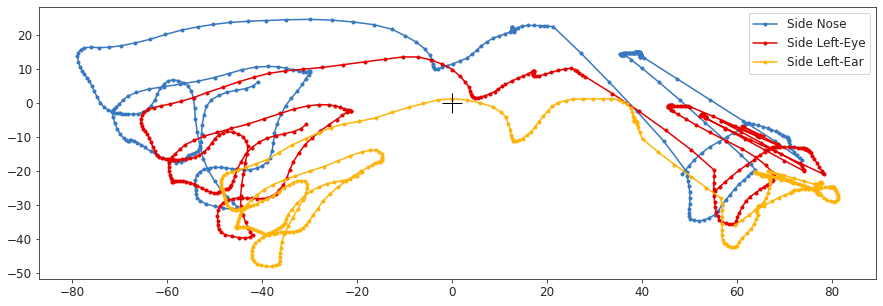

In [20]:
iTrial = 5
fig, ax = plt.subplots(figsize=(15,5))

#Plot traces
ax.plot(data_list[iTrial][:,0],data_list[iTrial][:,1],'.-',color=usrplt.cc[0],label='Side Nose')
ax.plot(data_list[iTrial][:,2],data_list[iTrial][:,3],'.-',color=usrplt.cc[1],label='Side Left-Eye')
ax.plot(data_list[iTrial][:,4],data_list[iTrial][:,5],'.-',color=usrplt.cc[2],label='Side Left-Ear')

# dObs, nT = data_list[iTrial].shape
# #Connect Tracking to give sense of angle
# line_segments = LineCollection([[data_list[iTrial][0:2,i],data_list[iTrial][2:4,i]] for i in range(nT)],colors=usrplt.cc[8],alpha=0.5, linestyle='solid')
# ax.add_collection(line_segments)
# line_segments = LineCollection([[data_list[iTrial][2:4,i],data_list[iTrial][4:,i]] for i in range(nT)],colors=usrplt.cc[8],alpha=0.5, linestyle='solid')
# ax.add_collection(line_segments)

ax.legend()
ax.plot(0,0,'+k',ms=20)
# x = data_df.loc[iExp]['Side TakeFL x']; y = data_df.loc[iExp]['Side TakeFL y']; confidence = data_df.loc[iExp]['Side TakeFL likelihood']
# indy = np.where(confidence > 0.8)[0]
# ax.plot(x[indy],y[indy],'.k',label='Side TakeFL')



In [21]:
##===== Fit ARHMM to data =====##
_, dObs = data_list[0].shape

#HMM parameters
#Let's start with 10 states
K = 8
N_iters=200

#Initialize basic ARHMM object 
#lots of parameters we can change; 
# we can make the transitions sticky or change the probability of transition given some external input;
# we can also change the observation class to "robust_autoregressive", which 
arhmm = ssm.HMM(K, dObs, transitions='standard', observations="autoregressive") 

#Fit model to data
hmm_lls = arhmm.fit(data_list, method="em", num_iters=N_iters,tolerance=1E-6)

In [24]:
color_names_K = usrplt.color_names[:K]; color_names_K.append(usrplt.color_names[-1])
color_palette = sns.xkcd_palette(color_names_K)
cmap = usrplt.gradient_cmap(sns.xkcd_palette(usrplt.color_names[:K]))

In [ ]:
#Loop over trials and get the maximum a posteriori probability estimate of the latent states
MAP_list = []; posterior_list = []; mask_list = []

for data in data_list:
    expected_states, expected_joints, log_likes = arhmm.expected_states(data)

    MAP_list.append(np.argmax(expected_states,axis=1))
    posterior_list.append(expected_states)
    mask_list.append(np.max(expected_states,axis=1) > 0.8)


In [17]:
##===== Save state sequences =====##
ioh5.save('./results/preparatory_behavior_K-{}_ARHMM.h5'.format(K), {'MAP_list':MAP_list, 'posterior_list':posterior_list,'mask_list': mask_list})

/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


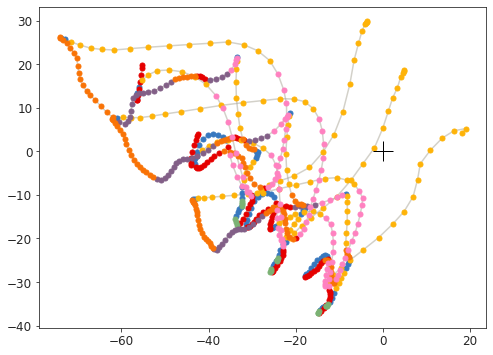

In [311]:
##===== Let's look at the states! =====##
iTrial = 0
mapseq = MAP_list[iTrial]
data = data_list[iTrial]

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(data_list[iTrial][:,0],data_list[iTrial][:,1],'-',color=usrplt.cc[-1],alpha=0.5)
ax.plot(data_list[iTrial][:,2],data_list[iTrial][:,3],'-',color=usrplt.cc[-1],alpha=0.5)
ax.plot(data_list[iTrial][:,4],data_list[iTrial][:,5],'-',color=usrplt.cc[-1],alpha=0.5)

for state in np.unique(mapseq):
    indy = np.where(mapseq == state)[0]
    #Plot traces
    ax.plot(data[indy,0],data[indy,1],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data[indy,2],data[indy,3],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data[indy,4],data[indy,5],'.',color=usrplt.cc[state],ms=10)

ax.plot(0,0,'+k',ms=20)
ax.set_aspect('equal', adjustable='box',share=True)
# ax.set_xlim([-75,75])
# ax.set_ylim([-75,75])


In [71]:
##===== Calculate state duration and state usage =====##
state_duration_list, state_startend_list, state_usage = util.get_state_durations(MAP_list, mask_list, K)

/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


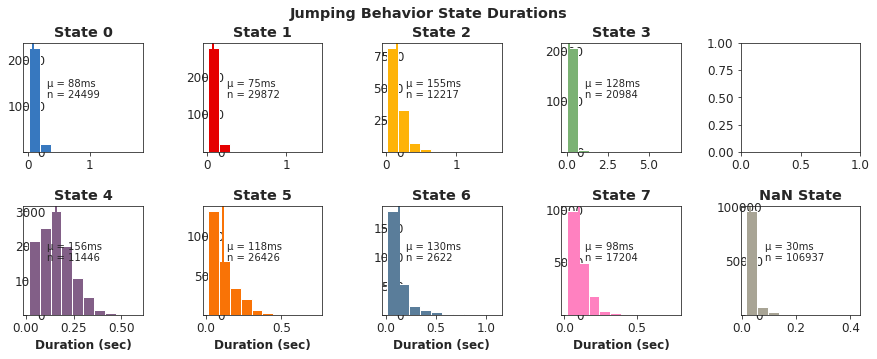

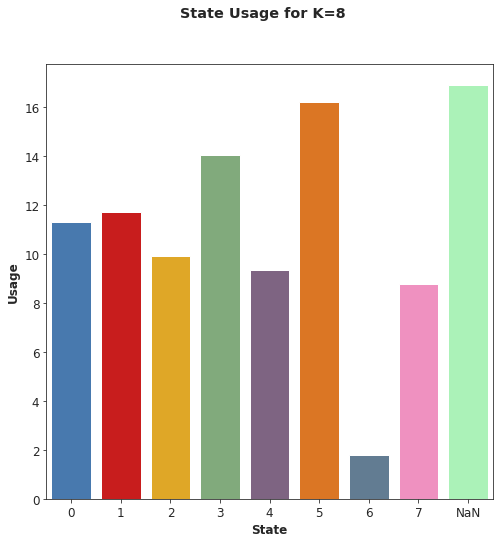

In [264]:
#Plot
usrplt.plot_state_durations(state_duration_list,state_usage, K)

In [ ]:
## Plot the actual AR matrices, with their corresponding fixed point
usrplt.plot_AR_matrices(arhmm)
    

In [267]:
samp_rate

60

In [30]:
dxdy = []
# What is the average distance between points?
for data in data_list:
    dxdy_nose_eye = [data[:,0]-data[:,2],data[:,1]-data[:,3]]
    dxdy_eye_ear = [data[:,2]-data[:,4],data[:,3]-data[:,5]]
    
    dxdy.append([np.mean(dxdy_nose_eye,axis=1),np.mean(dxdy_eye_ear,axis=1)])
average_dx_dy = np.mean(dxdy,axis=0)
average_dx_dy

array([[-10.82328051,  10.58991895],
       [-12.93093803,  11.62390074]])

In [258]:
arhmm.D

6

In [ ]:
usrplt.plot_dynamics_2d(arhmm)

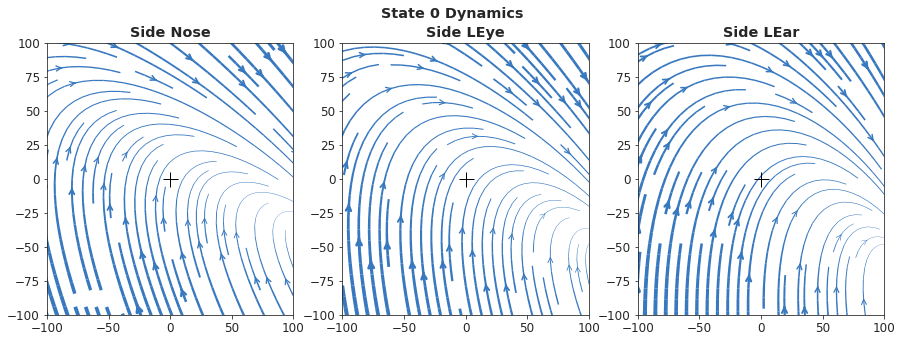

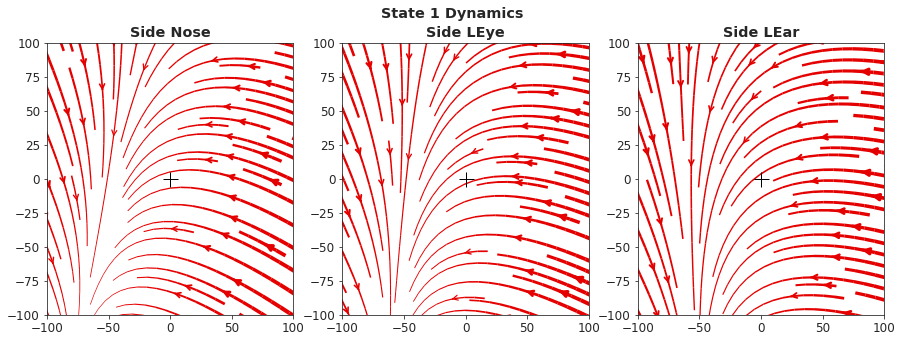

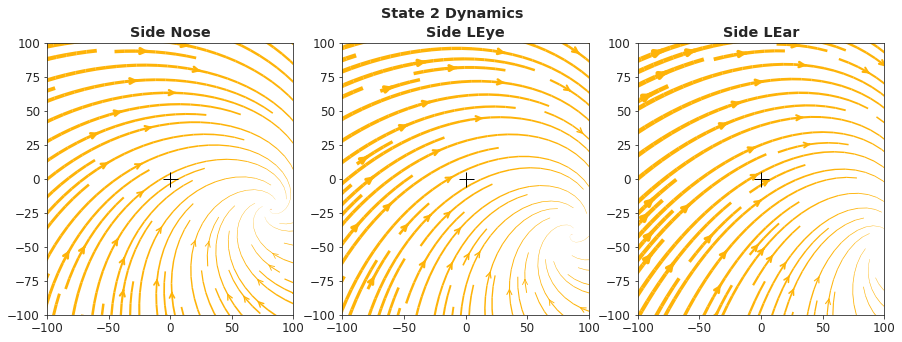

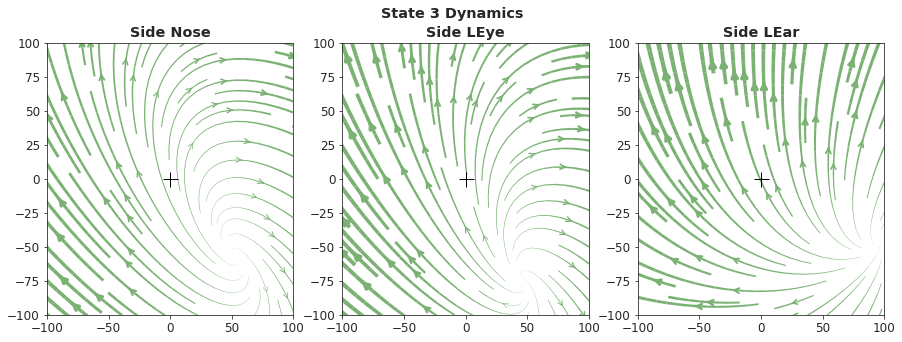

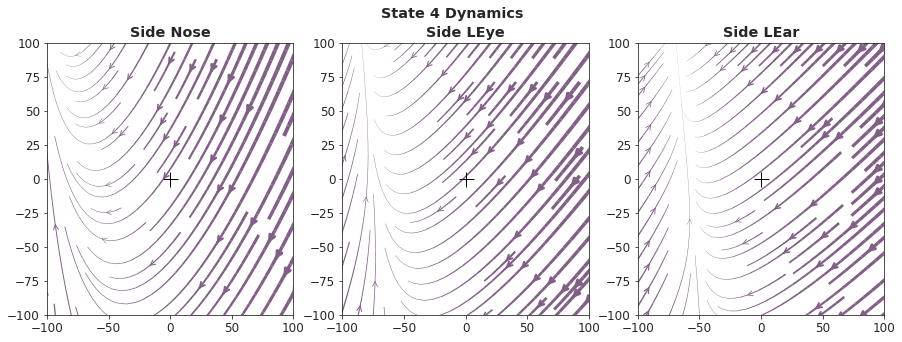

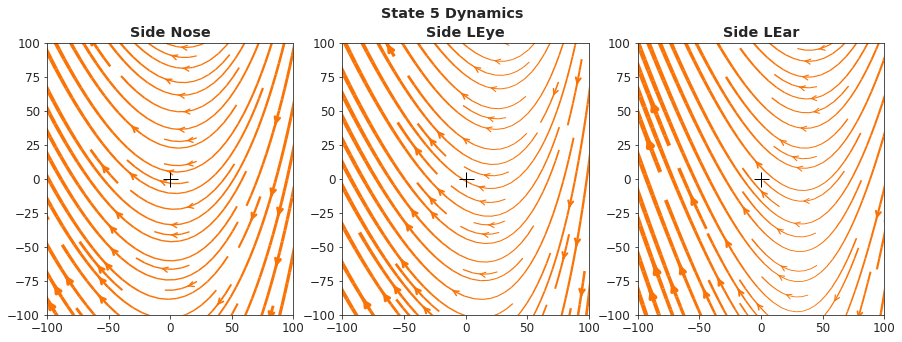

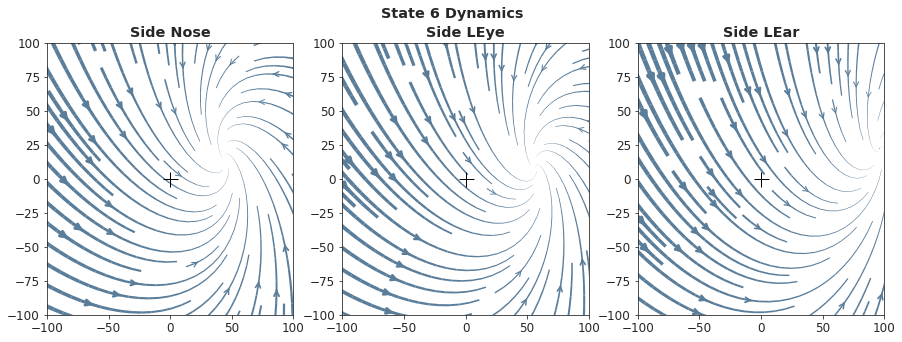

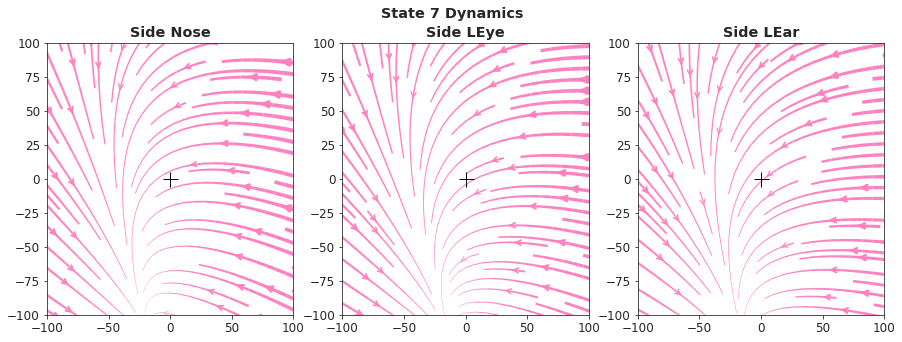

In [124]:
mins=(-125,-125)
maxs=(125,125)
npts=35

##===== Let's visualize the dynamics of each state  =====## 
for iState in range(K):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('State {} Dynamics'.format(iState))

    #Get AR process parameters
    AR = arhmm.observations.As[iState]
    bias = arhmm.observations.bs[iState]

    #Create grid of points
    x_grid, y_grid = np.meshgrid(np.linspace(mins[0], maxs[0], npts), np.linspace(mins[1], maxs[1], npts))
    nX,nY = x_grid.shape
    xy_grid_nose = np.column_stack((x_grid.ravel(), y_grid.ravel(), np.zeros((npts**2,0))))
    #Using average distance between nose and eye, and eye and ear, create separate grids for those points
    xy_grid_leye = xy_grid_nose - average_dx_dy[0,:]
    xy_grid_lear = xy_grid_leye - average_dx_dy[1,:]
    xy_grid_3pts = np.hstack((xy_grid_nose,xy_grid_leye,xy_grid_lear))

    #Create delta grid
    dx = xy_grid_3pts.dot(AR.T) + bias - xy_grid_3pts
    dx = dx.reshape((nX,nY,-1))

    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        AR = arhmm.observations.As[iState]
        bias = arhmm.observations.bs[iState]
        ax = axes[ii]

        #Calculate speed for linewidth
        speed = np.sqrt(dx[:,:,ii*2]**2 + dx[:,:,ii*2+1]**2)
        #Better than a quiver plot
        ax.streamplot(xy_grid_3pts[:,ii*2].reshape((nX,nY)), xy_grid_3pts[:,ii*2+1].reshape((nX,nY)), dx[:,:,ii*2], dx[:,:,ii*2+1],
                      color=usrplt.cc[iState],arrowsize=1.25,arrowstyle='->',linewidth= 5*speed / speed.max())

    #     axes[ii].quiver(xy_grid_3pts[:,ii*2], xy_grid_3pts[:,ii*2+1], dx[:, ii*2], dx[:,ii*2+1],color=usrplt.cc[iState])
        ax.set_title('Side {}'.format(ptstr))
        ax.set_xlim([-100,100]); ax.set_ylim([-100,100])
        ax.plot(0,0,'+k',ms=15)



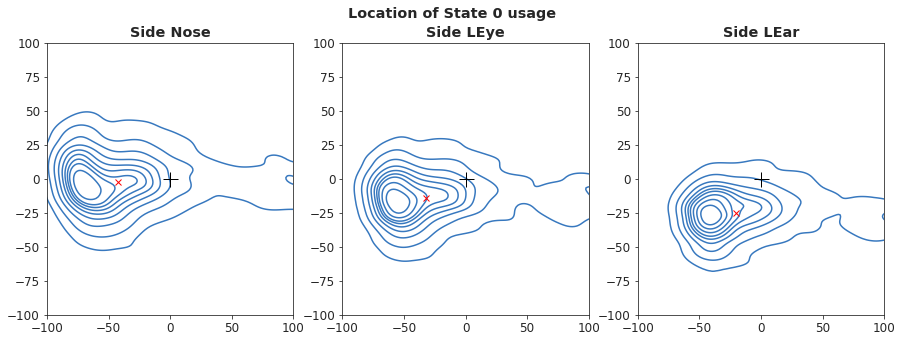

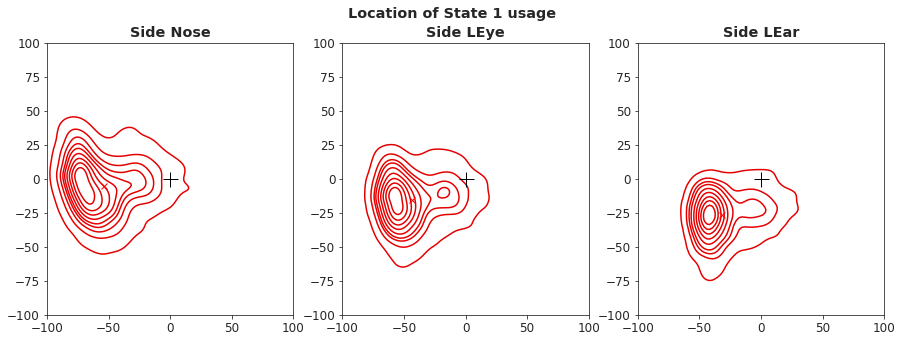

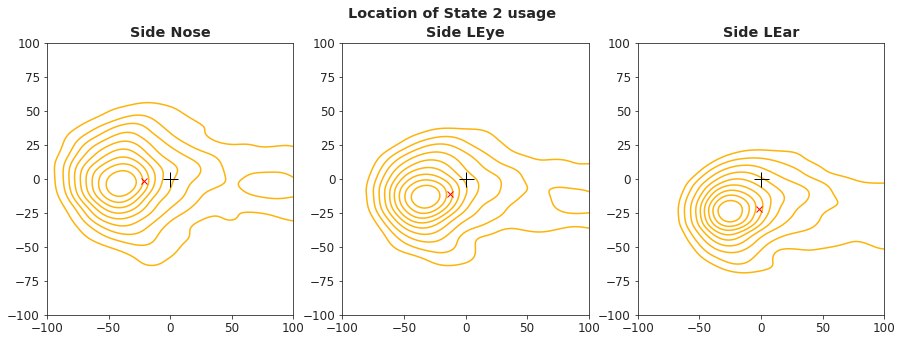

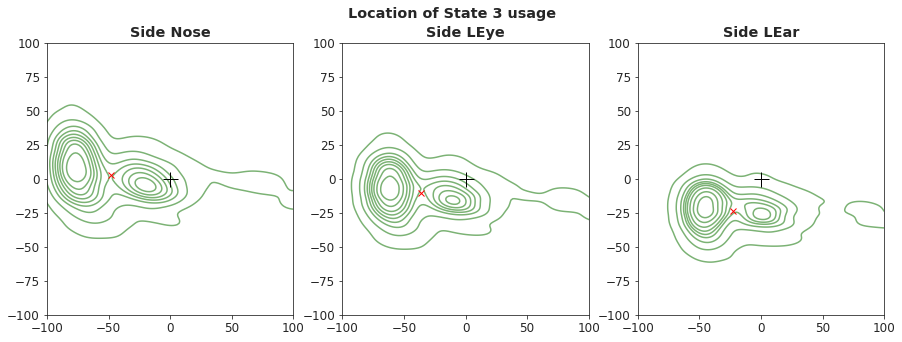

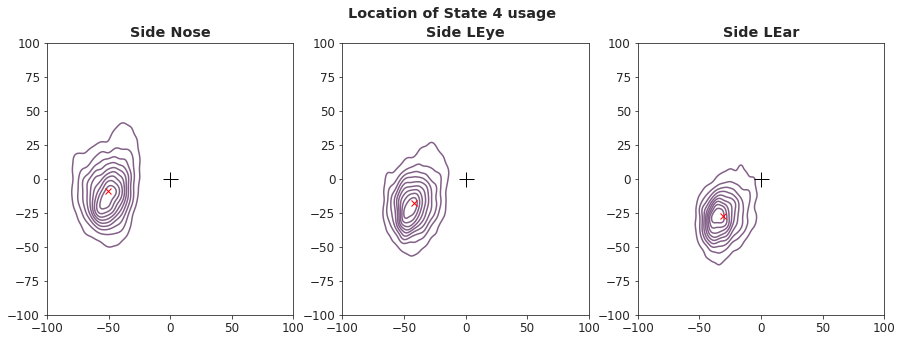

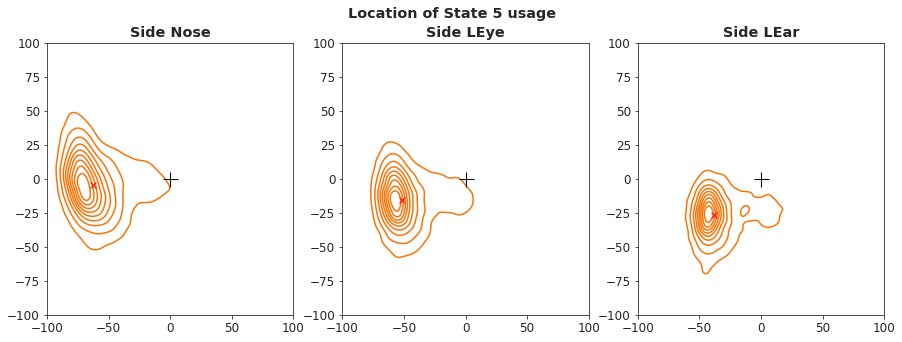

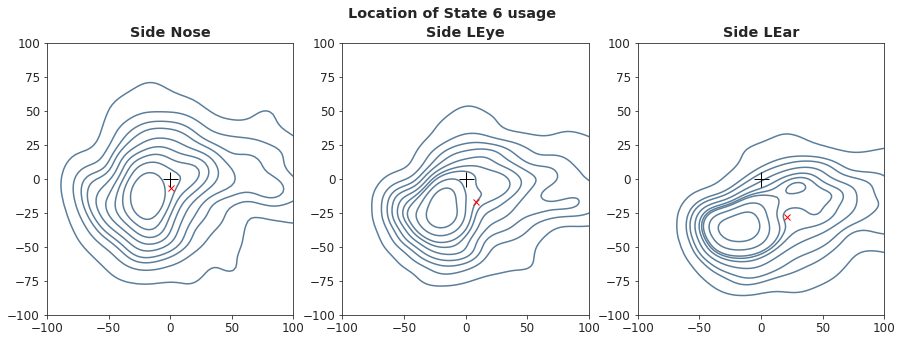

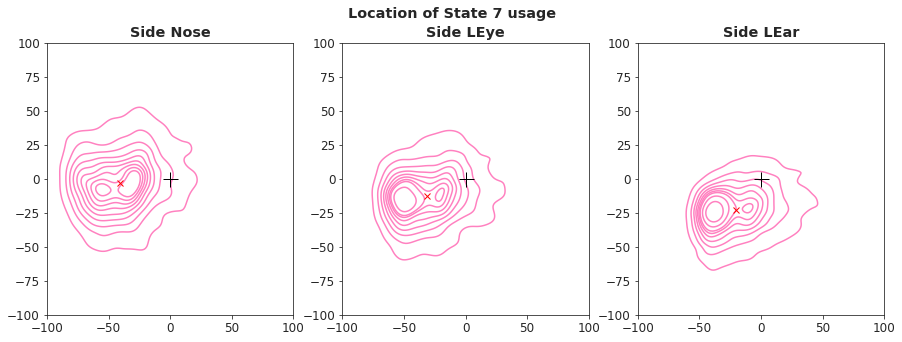

In [32]:
##===== Fit 2D gaussian to location where state is used =====##
state_locations = []


for state in range(K):
    tmp = []
    for data, mapseq in zip(data_list,MAP_list):
        indy = np.where(mapseq == state)[0]
        if len(indy) == 0:
            continue
        tmp.append(data[indy,:])
    
    state_locations.append(np.concatenate(tmp))

mlocations = []
for iState in range(K):
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('Location of State {} usage'.format(iState))
    nBins, _ = state_locations[iState].shape
    sloc = state_locations[iState]
    if nBins < 5000:
        indy = np.arange(nBins)
    else:
        indy = np.random.randint(0, high=nBins, size=5000)
        
    tmp = []
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        ax = axes[ii]
        sns.kdeplot(x=sloc[indy,2*ii],y=sloc[indy,ii*2+1],color=usrplt.cc[iState],ax=ax)
        ax.plot(np.mean(sloc[indy,2*ii],axis=0),np.mean(sloc[indy,ii*2+1],axis=0),'xr')
        ax.set_title('Side {}'.format(ptstr))
        ax.plot(0,0,'+k',ms=15)
        ax.set_xlim([-100,100]); ax.set_ylim([-100,100])
    mlocations.append(tmp)
    
    
    

In [ ]:
usrplt.plot_example_trajectories(state_duration_list,state_startend_list,data_list, arhmm, simulated=True)

In [97]:
# Calculate the max state duration for each state on each trial
state_durations_max = np.zeros((nTrials,K))
for iTrial, sd_trial in enumerate(state_duration_list):
    for iState, sd in enumerate(sd_trial[:-1]):
        if len(sd) == 0:
            state_durations_max[iTrial,iState] = 0
        else:
            state_durations_max[iTrial,iState] = np.max(sd)


In [ ]:


# pdfdoc = PdfPages(os.path.join('./plots/','example_trajectories_per-state.pdf'))
nTraces = 75
for iState in range(K):    

    #Get trial indices sorted by state duration for state
    trial_indices = np.argsort(state_durations_max[:,iState],axis=0)[::-1]
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('Top {} longest traces for State {} '.format(nTraces,iState))
    
    #Loop over trials and plot actual traces
    for iTrial in trial_indices[:nTraces]:
        #Get the correct index
        indy = np.argmax(state_duration_list[iTrial][iState])
        iS = state_startend_list[iTrial][iState][indy,0]
        iE = state_startend_list[iTrial][iState][indy,1]-1
        
        #Get data
        data = data_list[iTrial]

        for iPt, ptstr in enumerate(['Nose','LEye','LEar']):
            ax = axes[iPt]
            ax.plot(data[slice(iS,iE),2*iPt],data[slice(iS,iE),2*iPt+1],'-k')#,color=usrplt.cc[iState],lw=2)
            
            ax.plot(data[iS,2*iPt],data[iS,2*iPt+1],'s',color='w',markersize=6,markeredgecolor='k',markeredgewidth=1)#color=usrplt.cc[iState])
            ax.plot(data[iE,2*iPt],data[iE,2*iPt+1],'o',color=usrplt.cc[iState],markersize=6,markeredgecolor='k',markeredgewidth=1)
            ax.plot(0,0,'+k',ms=15)
            ax.set_xlim([-100,100]); ax.set_ylim([-100,100])
            
        
#     plt.show()
#     pdb.set_trace()
#     #Save and close
#     pdfdoc.savefig(fig)
#     plt.close(fig)
# pdfdoc.close()

In [ ]:


# pdfdoc = PdfPages(os.path.join('./plots/','example_trajectories_per-state.pdf'))
nTraces = 75
for iState in range(K):    

    #Get trial indices sorted by state duration for state
    trial_indices = np.argsort(state_durations_max[:,iState],axis=0)[::-1]
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    plt.suptitle('Top {} longest simulated traces for State {} '.format(nTraces,iState))
    
    #Loop over trials and plot actual traces
    for iTrial in trial_indices[:nTraces]:
        #Get the correct index
        indy = np.argmax(state_duration_list[iTrial][iState])
        nT = np.max(state_duration_list[iTrial][iState])
        iS = state_startend_list[iTrial][iState][indy,0]

        #Get initial starting position and simulate x-trace
        x0 = data_list[iTrial][iS,:]
        data_model = np.zeros((nT,dObs))
        data_model[0,:] = x0; pad = 0
        tmp_stateseq = np.repeat(iState,nT)
        for iT in range(1,nT):
            data_model[iT,:] = arhmm.observations.sample_x(tmp_stateseq[iT], data_model[:iT,:],input = np.zeros((nT+pad,)), with_noise=False)
            
        for iPt, ptstr in enumerate(['Nose','LEye','LEar']):
            ax = axes[iPt]
            ax.plot(data_model[:,2*iPt],data_model[:,2*iPt+1],'-k')#,color=usrplt.cc[iState],lw=2)
            
            ax.plot(data_model[0,2*iPt],data_model[0,2*iPt+1],'s',color='w',markersize=6,markeredgecolor='k',markeredgewidth=1)#color=usrplt.cc[iState])
            ax.plot(data_model[nT-1,2*iPt],data_model[nT-1,2*iPt+1],'o',color=usrplt.cc[iState],markersize=6,markeredgecolor='k',markeredgewidth=1)
            ax.plot(0,0,'+k',ms=15)
            ax.set_xlim([-100,100]); ax.set_ylim([-100,100])
            
        
#     plt.show()
#     pdb.set_trace()
#     #Save and close
#     pdfdoc.savefig(fig)
#     plt.close(fig)
# pdfdoc.close()

<AxesSubplot:title={'center':'State Transition Matrix for ARHMM'}>

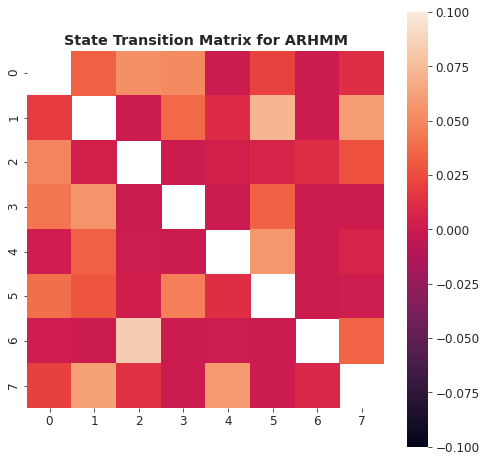

In [304]:
plt.figure(figsize = (8,8))
plt.title('State Transition Matrix for ARHMM')

#Plot heatmap without diagonal; just place annotated transition probabilities there
transition_matrix = arhmm.transitions.transition_matrix
diag_trans_matrix = np.zeros((K,K)); diag_trans_matrix[:] = np.nan
diag_trans_matrix[np.diag_indices(K)] = np.diag(transition_matrix)
transition_matrix[np.diag_indices(K)] = np.nan

sns.heatmap(transition_matrix,square=True,cbar=True,vmin=0,vmax=np.max(transition_matrix[:]))
# sns.heatmap(diag_trans_matrix,square=True,annot=True,cbar=True,vmin=0,vmax=np.max(transition_matrix[:]),cbar_kws={'shrink':0.5})

In [16]:
MAP_list_sorted = sorted(MAP_list, key=len)[::-1]
mask_list_sorted = sorted(mask_list, key=len)[::-1]

In [47]:
len(MAP_list_sorted[100])

1003

In [17]:
max_trial_length = len(MAP_list_sorted[100])

#Let's look at the 500 longest state sequences together in a 
zs = np.zeros((200,max_trial_length)); zs[:] = np.nan

for iTrial in range(200):
    indy = np.where(mask_list_sorted[iTrial+100])
    mapseq = MAP_list_sorted[iTrial+100]
    nT = len(mapseq);indy = np.arange(nT)
    zs[iTrial,indy] = mapseq


/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Trial Length (s)')

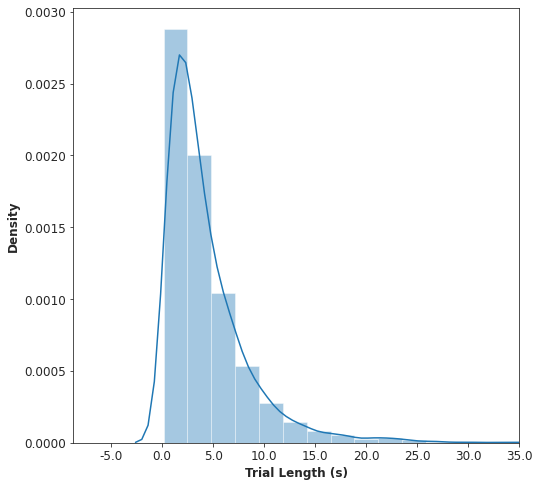

In [201]:
trial_lengths = np.array([len(data) for data in data_list])

fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(trial_lengths,ax=ax)
ax.set_xlim(xmax=2000)
xticks = np.arange(-300,2101,300)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks/60)
ax.set_xlabel('Trial Length (s)')


In [253]:
np.max(trial_lengths)/60

116.93333333333334

In [214]:
indy = np.argsort(trial_lengths[trial_indices],kind='stable')[::-1]
trial_lengths[trial_indices[indy]]
indy

array([  19,    9,  442, ..., 3640, 3567, 3530])

In [210]:
nTraces = 100
for iState in range(K):    

    #Get trial indices sorted by state duration for this state
    trial_indices = np.argsort(state_durations_max[:,iState],axis=0)[::-1]
    trial_lengths_sd = trial_lengths[trial_indices]
    
    #Also sort trials by trial length
    indy = np.argsort(trial_lengths)[::-1]
    
    #Get the trials that are less than 10seconds
    pos = np.where(trial_lengths[indy] < 600)
    
    
    test = trial_indices[indy[pos]]
    pdb.set_trace()
    
    
    
    
    
    max_trial_length = np.max([len(MAP_list[iT]) for iT in trial_indices[:nTraces]])

    #Let's look at the 500 longest state sequences together in a 
    zs = np.zeros((nTraces,max_trial_length)); zs[:] = np.nan
    
    #Loop over trials and get MAPseq
    for ii,iTrial in enumerate(trial_indices[:nTraces]):
        indy = np.arange(0,len(MAP_list[iTrial]))
        zs[ii,indy] = MAP_list[iTrial]
        
    fig, ax = plt.subplots(figsize=(10,5))
    
    plt.imshow(zs,cmap=cmap)
    
    plt.show()
    pdb.set_trace()

> <ipython-input-210-2698478ff1dc>(22)<module>()
     20 
     21 
---> 22     max_trial_length = np.max([len(MAP_list[iT]) for iT in trial_indices[:nTraces]])
     23 
     24     #Let's look at the 500 longest state sequences together in a



ipdb>  test


array([2590, 2580, 2282, ..., 2736, 2278, 2782])


ipdb>  trial_lengths[2590]


7016


ipdb>  trial_lengths_sd[2590]


147


ipdb>  trial_lengths[test]


array([7016, 3805, 3577, ...,    9,    9,    9])


ipdb>  q


BdbQuit: 

In [199]:
ii

100

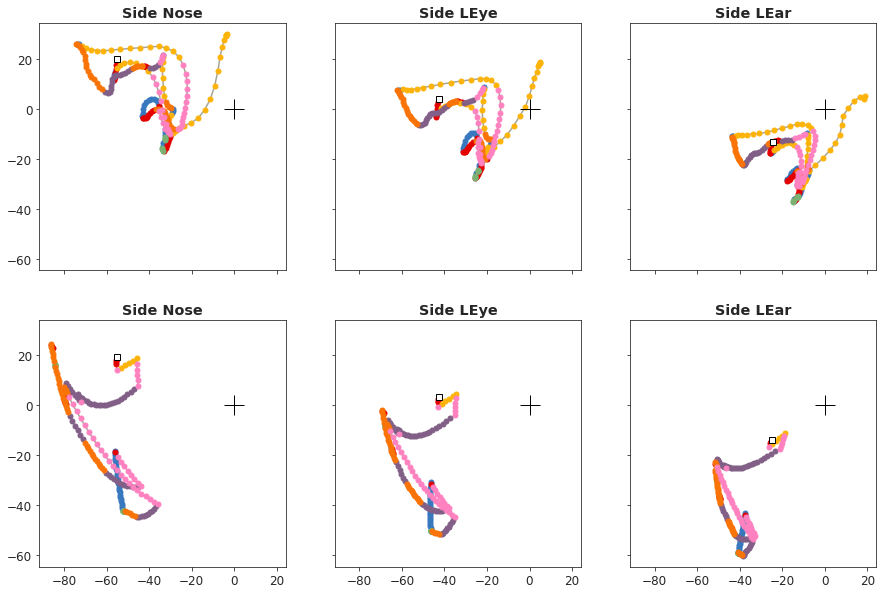

In [174]:
iTrial = 0
mapseq = MAP_list[iTrial]
data = data_list[iTrial]

nT,_ = data.shape

fig, axes = plt.subplots(2,3,figsize=(15,10),sharex='all', sharey='all' )

#Plot actual traces 
for jj,ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[0,jj]
    ax.set_title('Side {}'.format(ptstr))
    ax.plot(data[:,jj*2],data[:,jj*2+1],'-',color=usrplt.cc[-1])
    for state in np.unique(mapseq):
        indy = np.where(mapseq == state)[0]
        #Plot traces
        ax.plot(data[indy,jj*2],data[indy,jj*2+1],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data[0,jj*2],data[0,jj*2+1],'s',color='w',markersize=6,markeredgecolor='k',markeredgewidth=1)
    ax.plot(0,0,'+k',ms=20)

# start_state = (np.array([4],dtype=int),mean_initial_position.reshape(1,dObs))
start_state = (mapseq[:1],data[:1,:])
z_sim, data_sim = arhmm.sample(nT,prefix=start_state,with_noise=False)

#Plot simulated traces
for jj,ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[1,jj]
    ax.set_title('Side {}'.format(ptstr))
    
    ax.plot(data_sim[:,jj*2],data_sim[:,jj*2+1],'-',color=usrplt.cc[-1])
    for state in np.unique(z_sim):
        indy = np.where(z_sim == state)[0]
        #Plot traces
        ax.plot(data_sim[indy,jj*2],data_sim[indy,jj*2+1],'.',color=usrplt.cc[state],ms=10)
    ax.plot(data_sim[0,jj*2],data_sim[0,jj*2+1],'s',color='w',markersize=6,markeredgecolor='k',markeredgewidth=1)
    ax.plot(0,0,'+k',ms=20)

# plt.savefig('./plots/simulated-vs-actual_trajectories_trial{:03d}.png'.format(iTrial))


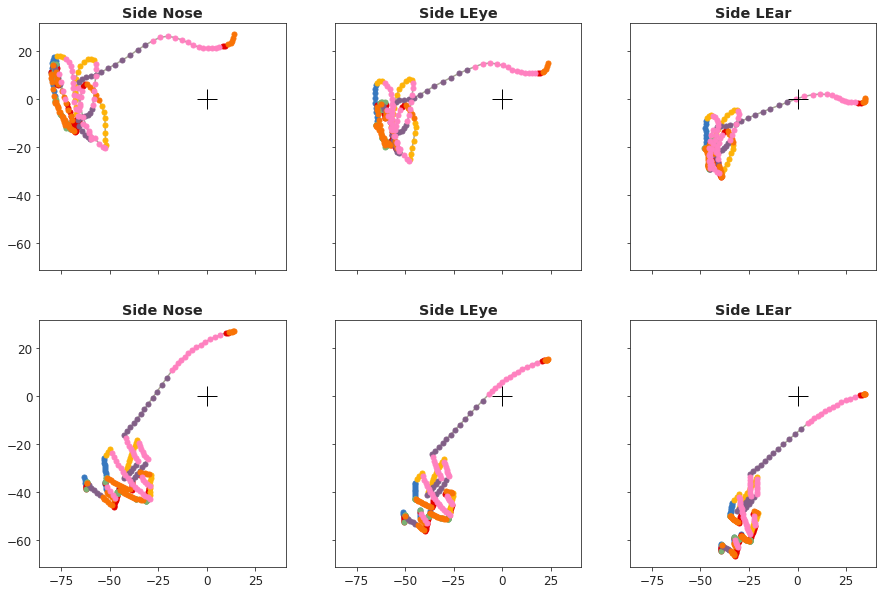

In [247]:
iTrial = 19
mapseq = MAP_list[iTrial]
data = data_list[iTrial]

nT,_ = data.shape



fig, axes = plt.subplots(2,3,figsize=(15,10),sharex='all', sharey='all' )

#Plot actual traces 
for jj,ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[0,jj]
    ax.set_title('Side {}'.format(ptstr))
    ax.plot(data[:,jj*2],data[:,jj*2+1],'-',color=usrplt.cc[-1])
    for state in np.unique(mapseq):
        indy = np.where(mapseq == state)[0]
        #Plot traces
        ax.plot(data[indy,jj*2],data[indy,jj*2+1],'.',color=usrplt.cc[state],ms=10)

    ax.plot(0,0,'+k',ms=20)


#Instead of using the model - transition matrix + AR matrices - to evolve from a starting position and state,
#let's take the state sequence that was determined for a given trial and just sample the observations
data_model = np.zeros(data.shape)
data_model[0,:] = data[0,:]; pad = 0
for iT in range(1,nT):
    data_model[iT,:] = arhmm.observations.sample_x(mapseq[iT], data_model[:iT,:],input = np.zeros((nT+pad,)), with_noise=False)
    
#Plot simulated traces
for jj,ptstr in enumerate(['Nose','LEye','LEar']):
    ax = axes[1,jj]
    ax.set_title('Side {}'.format(ptstr))
    ax.plot(data_model[:,jj*2],data_model[:,jj*2+1],'-',color=usrplt.cc[-1])
    for state in np.unique(mapseq):
        indy = np.where(mapseq == state)[0]
        #Plot traces
        ax.plot(data_model[indy,jj*2],data_model[indy,jj*2+1],'.',color=usrplt.cc[state],ms=10)

    ax.plot(0,0,'+k',ms=20)

# plt.savefig('./plots/simulated-vs-actual_trajectories_trial{:03d}.png'.format(iTrial))
